In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import scipy as sci
import matplotlib
import scikit_posthocs as sci_posthocs

import analysis as ana
import plot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', None)

In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {'family':'CMU Serif', 
               #'sans-serif':['Helvetica'],
               'size': 11}
mpl.rc('font', **font)

# Loading Data

In [184]:
# brain_data, cog_data, subj_data = ana.load_data('../data')
brain_data_z, cog_data_z, subj_data = ana.load_data('../data_zscore')
# brain_data_q, cog_data_q, subj_data = ana.load_data('../data_quant')

In [185]:
cog_data_z.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1010 to 4024
Columns: 47 entries, sex to wasi201_iqscores_full2iq
dtypes: float64(46), int64(1)
memory usage: 58.1 KB


### removing multicolinearity

In [186]:
cog_data_z_ = cog_data_z.drop(['deldisk01_auc_40000', 'er4001_er40_c_fpa'], axis=1)

# deldisk01_auc_40000 - deldisk01_sv_3yr_40000, deldisk01_sv_5yr_40000,  deldisk01_sv_10yr_40000
# cogcomp01_nih_crycogcomp_unadjusted - orrt01_read_acss, tpvt01_tpvt_acss
# wasi201_iqscores_full2iq - wasi201_vocab_totalrawscore, wasi201_matrix_totalrawscore
#'wasi201_vocab_totalrawscore', 'deldisk01_sv_3yr_40000',
#deldisk01_auc_40000

**Kaiser-Meyer-Olkin (KMO) Test** measures the suitability of data for factor analysis. Value of KMO less than 0.6 is considered inadequate.

In [187]:
kmo_all,kmo_model=calculate_kmo(cog_data_z_)
kmo_model

/home/katharina/anaconda3/envs/earlypsy/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7200416318693794

**Bartlett’s test of sphericity** checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysi

In [188]:
chi_square_value,p_value=calculate_bartlett_sphericity(cog_data_z_)
chi_square_value, p_value

(11563.468314831269, 0.0)

if the determinant is greater than 0.00001, then there is no
multicollinearity

In [113]:
from scipy.stats import chi2


def bartlett_sphericity(x):
    n, p = x.shape
    x_corr = (x - np.mean(x, axis=0)) / np.std(x, axis=0, ddof=0)
    x_corr = np.cov(x_corr, rowvar=False, ddof=0)

    corr_det = np.linalg.det(x_corr)
    print(corr_det)
    statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
    degrees_of_freedom = p * (p - 1) / 2
    p_value = chi2.sf(statistic, degrees_of_freedom)
    return statistic, p_value

In [114]:
chi_square_value,p_value=bartlett_sphericity(cog_data_z_)
chi_square_value,p_value

1.0413332692475091e-24


(8237.213102221736, 0.0)

In [189]:
fa = FactorAnalyzer(rotation=None)
fa.fit(cog_data_z_)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([1.25359012e+01, 4.78367119e+00, 2.81014405e+00, 2.35988599e+00,
       1.84856004e+00, 1.77034204e+00, 1.68752476e+00, 1.36681986e+00,
       1.29646525e+00, 1.16439895e+00, 1.09962992e+00, 1.02175772e+00,
       1.01114966e+00, 9.19429901e-01, 8.34875238e-01, 8.25300628e-01,
       6.86285472e-01, 6.44232645e-01, 6.11062793e-01, 5.38291956e-01,
       5.02978506e-01, 4.85659959e-01, 4.46830113e-01, 3.99170284e-01,
       3.81172209e-01, 3.56769951e-01, 3.36220095e-01, 3.14374570e-01,
       2.92498327e-01, 2.76301180e-01, 2.63623418e-01, 2.29750604e-01,
       2.02241022e-01, 1.66111014e-01, 1.39523800e-01, 1.21832926e-01,
       1.03789193e-01, 5.35825753e-02, 4.00036727e-02, 3.54138010e-02,
       1.97465367e-02, 1.08684446e-02, 5.50268677e-03, 3.05911409e-04,
       2.83832688e-16])

In [190]:
fa = FactorAnalyzer(13, rotation=None)
fa.fit(cog_data_z_)
cog_data_z_fa = fa.transform(cog_data_z_)

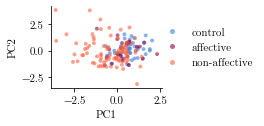

In [191]:
pl.plot_data_2D(cog_data_z_fa)

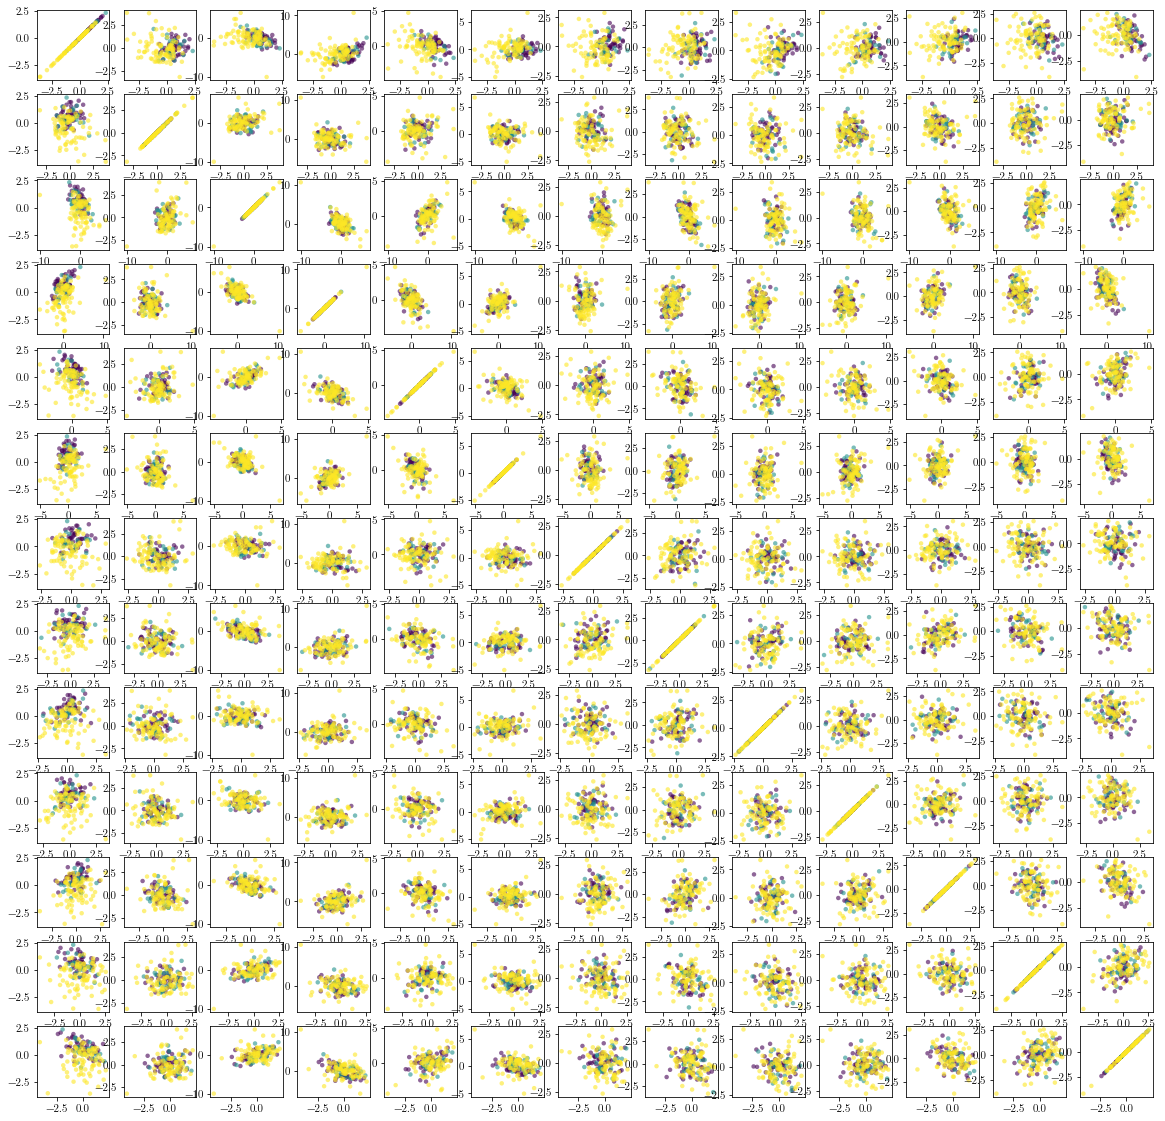

In [27]:
fig, ax = plt.subplots(13,13, figsize=(20,20))
f=0
for i in range(13):
    for j in range(13):
        ax.flatten()[f].scatter(cog_data_z_fa[:,i], cog_data_z_fa[:,j], 
                             c=subj_data['phenotype_description'], alpha=0.6, s=20, lw=0)
        f+=1

Cognitive Data, FA (z)
K-Means


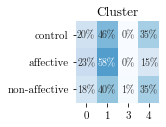

Spectral


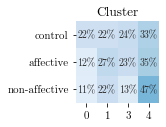

In [255]:
k=4
print('Cognitive Data, FA (z)')
print('K-Means')
df = ana.K_Means(cog_data_z_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(cog_data_z_fa, k)
pl.plot_cluster_result(df, k)

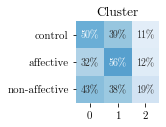

In [302]:
k=3
predict_brain, df = ana.Fuzzy(cog_data_z_fa, k)
pl.plot_cluster_result(df, k)

# Brain Data

In [198]:
brain_data_z_m = brain_data_z.drop(['23', '24', '28'], axis=1)

In [199]:
kmo_all,kmo_model=calculate_kmo(brain_data_z_m)
kmo_model

/home/katharina/anaconda3/envs/earlypsy/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7209065758681319

In [200]:
chi_square_value,p_value=calculate_bartlett_sphericity(brain_data_z_m)
chi_square_value, p_value

(2617.1534410132995, 0.0)

In [201]:
fa = FactorAnalyzer(rotation=None)
fa.fit(brain_data_z_m)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.63953964, 3.12730629, 2.74919565, 2.12873605, 1.44175123,
       1.14862687, 1.02702412, 0.90177485, 0.78011183, 0.75485026,
       0.6557885 , 0.57153835, 0.52295983, 0.45907555, 0.4285171 ,
       0.38360537, 0.37497247, 0.3382909 , 0.29094758, 0.27264025,
       0.22839248, 0.19244273, 0.1676501 , 0.14434784, 0.12410247,
       0.08004035, 0.06577134])

In [202]:
fa = FactorAnalyzer(7, rotation=None)
fa.fit(brain_data_z_m)
brain_data_z_fa = fa.transform(brain_data_z_m)

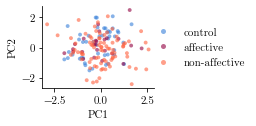

In [68]:
pl.plot_data_2D(brain_data_z_fa)

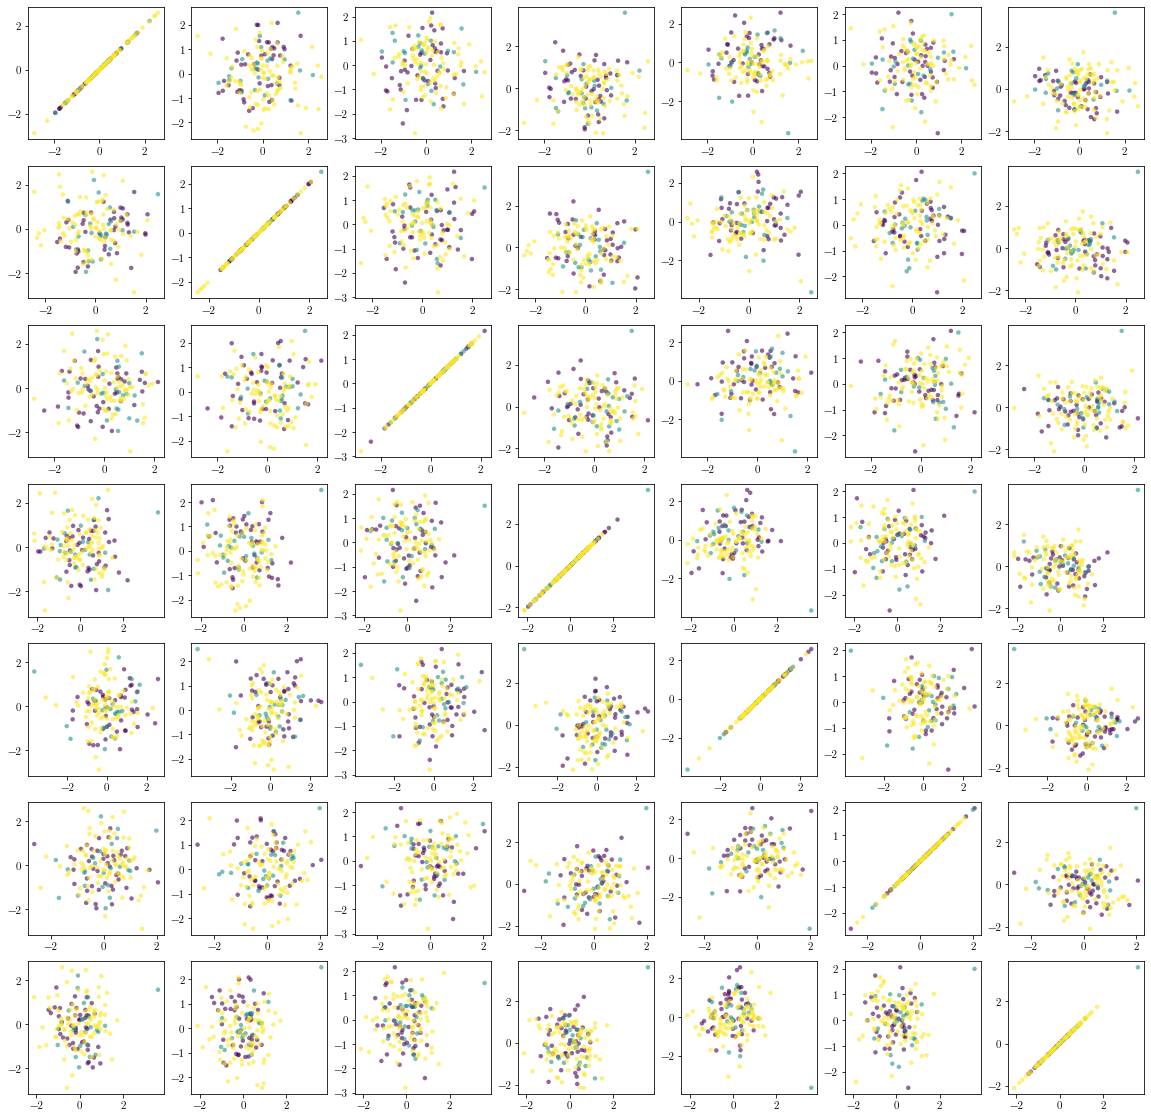

In [69]:
fig, ax = plt.subplots(7,7, figsize=(20,20))
f=0
for i in range(7):
    for j in range(7):
        ax.flatten()[f].scatter(brain_data_z_fa[:,i], brain_data_z_fa[:,j], 
                             c=subj_data['phenotype_description'], alpha=0.6, s=20, lw=0)
        f+=1

Brain Data, FA (z)
K-Means


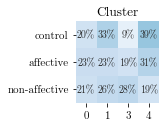

Spectral


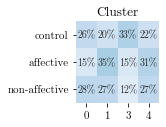

In [273]:
k=4
print('Brain Data, FA (z)')
print('K-Means')
df = ana.K_Means(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)

In [125]:
####################################################################################################

# Quanitle Normalization

### Loading Data

In [29]:
brain_data_q, cog_data_q, subj_data = ana.load_data('../data_quant')

In [38]:
cog_data_q.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1010 to 4024
Columns: 47 entries, sex to wasi201_iqscores_full2iq
dtypes: float64(46), int64(1)
memory usage: 58.1 KB


### PCA

In [85]:
pca = PCA()
pca.fit_transform(cog_data_q)
components = pca.components_
cog_data_z_pca = pca.transform(cog_data_q)
var = pca.explained_variance_ratio_

In [86]:
var_p = ana.permutation_test(cog_data_q, 5000)
var_p_mean = np.mean(var_p, axis=0)
t,p = sci.stats.ttest_1samp(var_p, var,alternative='less')
index_significant = np.where(p[:-1] != p[1:])[0][0]
print(sum(var[:index_significant+1]))
p

0.6001267280514404


array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

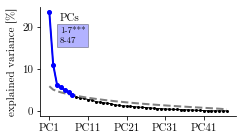

In [89]:
pl.plot_PC(cog_data_q, var, var_p_mean, index_significant)

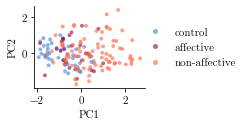

In [91]:
pl.plot_data_2D(cog_data_z_pca)

In [162]:
pca = PCA(7)
pca.fit_transform(cog_data_q)
components = pca.components_
cog_data_q_pca = pca.transform(cog_data_q)

cog Data, PCA (q)
K-Means


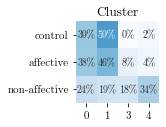

Spectral


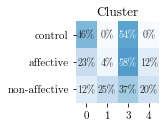

In [269]:
k=4
print('cog Data, PCA (q)')
print('K-Means')
df = ana.K_Means(cog_data_q_pca, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(cog_data_q_pca, k)
pl.plot_cluster_result(df, k)

In [164]:
pca = PCA()
pca.fit_transform(brain_data_q)
components = pca.components_
brain_data_q_pca = pca.transform(brain_data_q)
var = pca.explained_variance_ratio_

In [165]:
var_p = ana.permutation_test(brain_data_q, 5000)
var_p_mean = np.mean(var_p, axis=0)
t,p = sci.stats.ttest_1samp(var_p, var,alternative='less')
index_significant = np.where(p[:-1] != p[1:])[0][0]
print(sum(var[:index_significant+1]))
p

0.524120901739872


array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

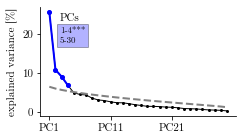

In [166]:
pl.plot_PC(brain_data_q, var, var_p_mean, index_significant)

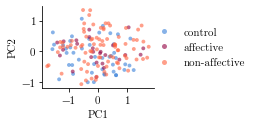

In [167]:
pl.plot_data_2D(brain_data_q_pca)

In [168]:
pca = PCA(7)
pca.fit_transform(brain_data_q)
components = pca.components_
brain_data_q_pca = pca.transform(brain_data_q)

brain Data, PCA (q)
K-Means


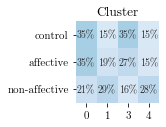

Spectral


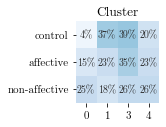

In [274]:
k=4
print('brain Data, PCA (q)')
print('K-Means')
df = ana.K_Means(brain_data_q_pca, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(brain_data_q_pca, k)
pl.plot_cluster_result(df, k)

### FA

**Kaiser-Meyer-Olkin (KMO) Test** measures the suitability of data for factor analysis. Value of KMO less than 0.6 is considered inadequate.

In [300]:
kmo_all,kmo_model=calculate_kmo(cog_data_q)
kmo_model

0.7207911786337788

**Bartlett’s test of sphericity** checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysi

In [301]:
chi_square_value,p_value=calculate_bartlett_sphericity(cog_data_q)
chi_square_value, p_value

(7571.033418071122, 0.0)

In [44]:
fa = FactorAnalyzer(rotation=None)
fa.fit(cog_data_q_)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([1.21514142e+01, 5.14954867e+00, 2.98707979e+00, 2.19298774e+00,
       2.02383169e+00, 1.83185316e+00, 1.68430550e+00, 1.62744792e+00,
       1.41234653e+00, 1.28663315e+00, 1.15753205e+00, 1.06493394e+00,
       1.03263649e+00, 9.71545424e-01, 9.16184803e-01, 8.74123144e-01,
       7.83985816e-01, 7.37454487e-01, 6.73874221e-01, 6.43972510e-01,
       5.69686510e-01, 4.88926755e-01, 4.80059801e-01, 4.45922345e-01,
       4.27486917e-01, 3.98131562e-01, 3.47581899e-01, 3.40605088e-01,
       3.02723269e-01, 2.91059275e-01, 2.63312276e-01, 2.30374503e-01,
       2.06443765e-01, 2.02117888e-01, 1.78227268e-01, 1.47647418e-01,
       1.33618932e-01, 9.51034972e-02, 8.24436148e-02, 6.39383087e-02,
       4.63203533e-02, 1.90636377e-02, 1.13949558e-02, 8.94081921e-03,
       7.75020661e-03, 7.15223216e-03, 2.75698608e-04])

In [46]:
fa = FactorAnalyzer(13, rotation=None)
fa.fit(cog_data_q_)
cog_data_q_fa = fa.transform(cog_data_q_)

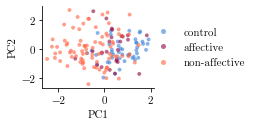

In [47]:
pl.plot_data_2D(cog_data_q_fa)

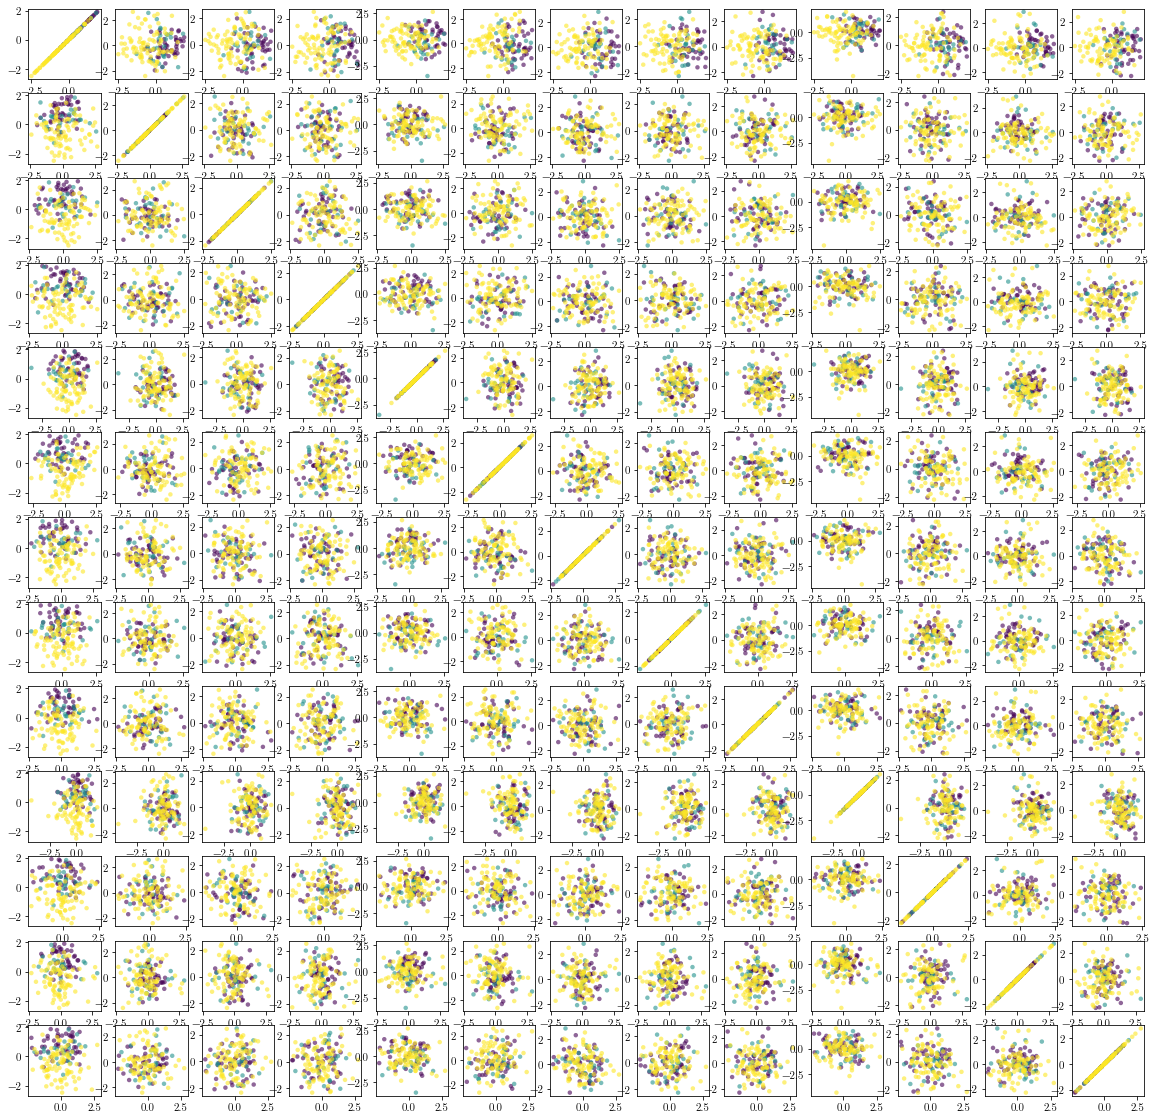

In [48]:
fig, ax = plt.subplots(13,13, figsize=(20,20))
f=0
for i in range(13):
    for j in range(13):
        ax.flatten()[f].scatter(cog_data_q_fa[:,i], cog_data_q_fa[:,j], 
                             c=subj_data['phenotype_description'], alpha=0.6, s=20, lw=0)
        f+=1

Cognitive Data, PCA
K-Means


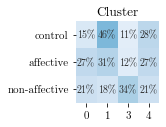

Spectral


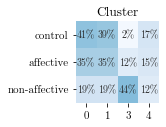

In [261]:
k=4
print('Cognitive Data, PCA')
print('K-Means')
df = ana.K_Means(cog_data_q_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(cog_data_q_fa, k)
pl.plot_cluster_result(df, k)

# Brain Data

In [206]:
brain_data_q_ = brain_data_q#.drop(['23', '24', '28'], axis=1)

In [207]:
kmo_all,kmo_model=calculate_kmo(brain_data_q_)
kmo_model

/home/katharina/anaconda3/envs/earlypsy/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6861669958349731

In [208]:
chi_square_value,p_value=calculate_bartlett_sphericity(brain_data_q_)
chi_square_value, p_value

(2601.458576487729, 1.7062216807618783e-304)

In [209]:
fa = FactorAnalyzer(rotation=None)
fa.fit(brain_data_q_)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.7008646 , 3.24497963, 2.71828504, 2.05885818, 1.46480824,
       1.33447574, 1.29732948, 1.04718437, 0.91043476, 0.86355326,
       0.76698796, 0.69725886, 0.6906676 , 0.62320768, 0.54473737,
       0.48263048, 0.41877274, 0.413863  , 0.39647781, 0.36057031,
       0.34327318, 0.30671847, 0.2484429 , 0.23181056, 0.21524376,
       0.17572748, 0.1420846 , 0.12630771, 0.10921972, 0.06522449])

In [211]:
fa = FactorAnalyzer(8, rotation=None)
fa.fit(brain_data_q_)
brain_data_q_fa = fa.transform(brain_data_q_)

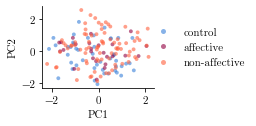

In [212]:
pl.plot_data_2D(brain_data_q_fa)

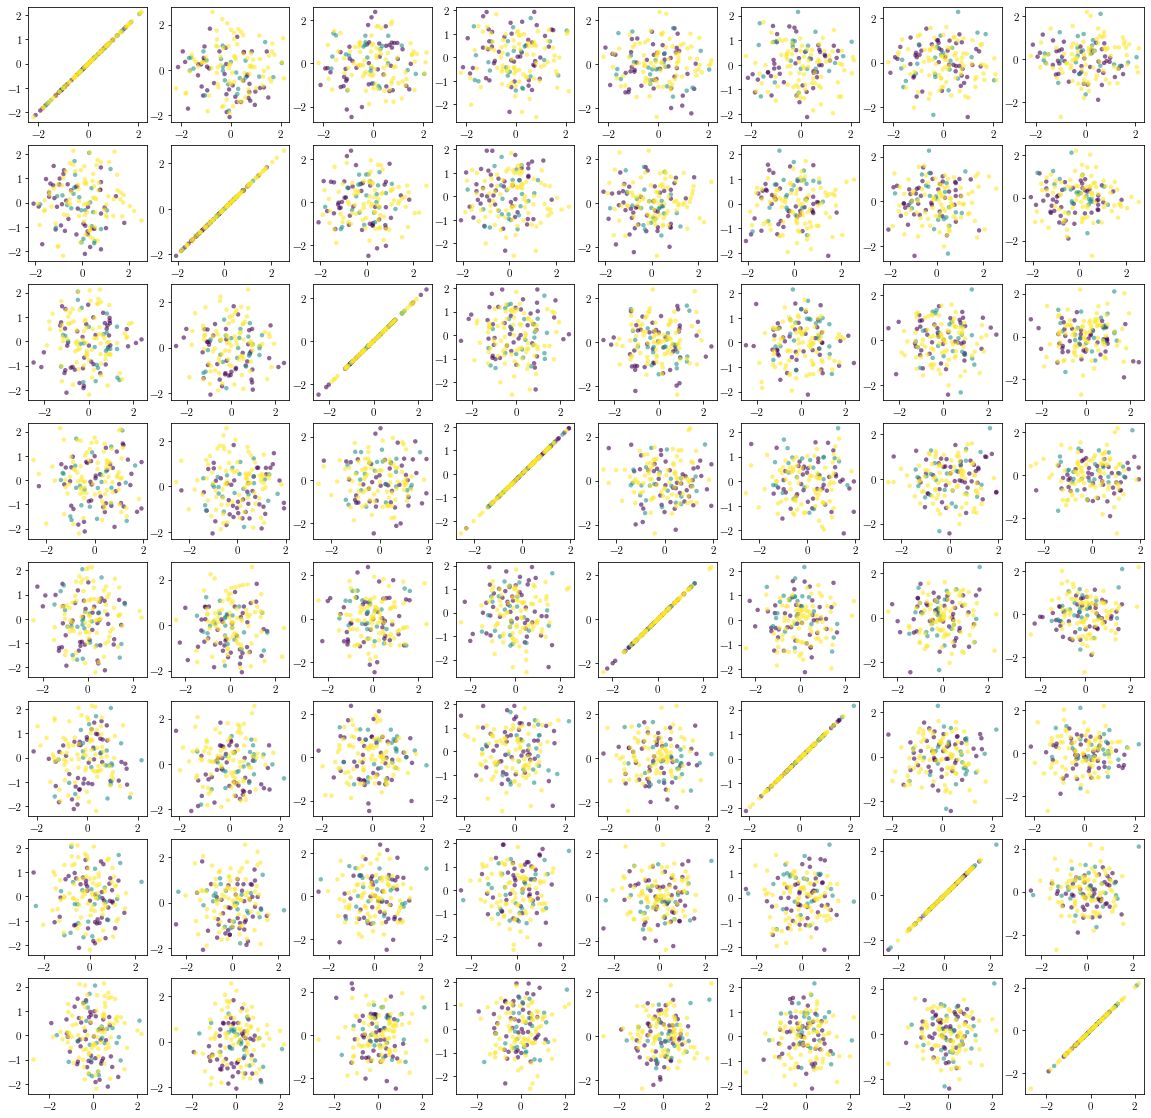

In [213]:
fig, ax = plt.subplots(8,8, figsize=(20,20))
f=0
for i in range(8):
    for j in range(8):
        ax.flatten()[f].scatter(brain_data_q_fa[:,i], brain_data_q_fa[:,j], 
                             c=subj_data['phenotype_description'], alpha=0.6, s=20, lw=0)
        f+=1

brain Data, FA (q)
K-Means


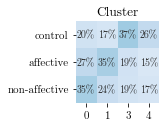

Spectral


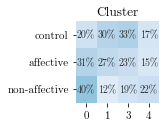

In [275]:
k=4
print('brain Data, FA (q)')
print('K-Means')
df = ana.K_Means(brain_data_q_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(brain_data_q_fa, k)
pl.plot_cluster_result(df, k)

# Mixed Approaches 

In [276]:
pca = PCA(6)
pca.fit_transform(cog_data_z)
components = pca.components_
cog_data_z_pca = pca.transform(cog_data_z)

In [277]:
all_data_z_pcafa = np.concatenate((cog_data_z_pca, brain_data_z_fa), axis=1)
all_data_z_pcafa.shape

(155, 13)

all Data, cog-PCA (z), brain-FA (z)
K-Means


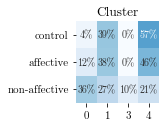

Spectral


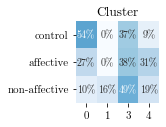

In [298]:
k=4
print('all Data, cog-PCA (z), brain-FA (z)')
print('K-Means')
df = ana.K_Means(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)

In [229]:
all_data_zq_pcafa = np.concatenate((cog_data_q_pca, brain_data_z_fa), axis=1)
all_data_zq_pcafa.shape

(155, 14)

all Data, cog-PCA (q), brain-FA (z)
K-Means


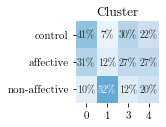

Spectral


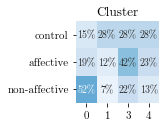

In [246]:
k=4
print('all Data, cog-PCA (q), brain-FA (z)')
print('K-Means')
df = ana.K_Means(all_data_zq_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(all_data_zq_pcafa, k)
pl.plot_cluster_result(df, k)

In [ ]:
all_data_zq_pcafa = np.concatenate((cog_data_q_pca, brain_data_q_pca), axis=1)
all_data_zq_pcafa.shape

all Data, cog-PCA (q), brain-PCA (q)
K-Means


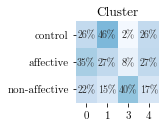

Spectral


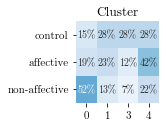

In [296]:
k=4
print('all Data, cog-PCA (q), brain-PCA (q)')
print('K-Means')
df = ana.K_Means(all_data_zq_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
df = ana.Spectral(all_data_zq_pcafa, k)
pl.plot_cluster_result(df, k)